This Kaggle challenge provides 5 years of store-item sales data, and asks to predict 3 months of sales for 50 different items at 10 different stores.

**Research Question:** What's the best way to deal with seasonality?

In [2]:
install.packages("prophet")
library(tidyverse)
library(caret)
library(dplyr)
library(DataExplorer)
library(MLmetrics)
library(prophet)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall


Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, a

Read in train and test data

In [3]:
train <- read_csv("../input/demand-forecasting-kernels-only/train.csv")
test <- read_csv("../input/demand-forecasting-kernels-only/test.csv")
all_data <- train %>% bind_rows(test)



── Column specification ────────────────────────────────────────────────────────
cols(
  date = col_date(format = ""),
  store = col_double(),
  item = col_double(),
  sales = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  id = col_double(),
  date = col_date(format = ""),
  store = col_double(),
  item = col_double()
)




**Exploratory Data Analys**

As seen below, the training dataset is not missing any datapoints.

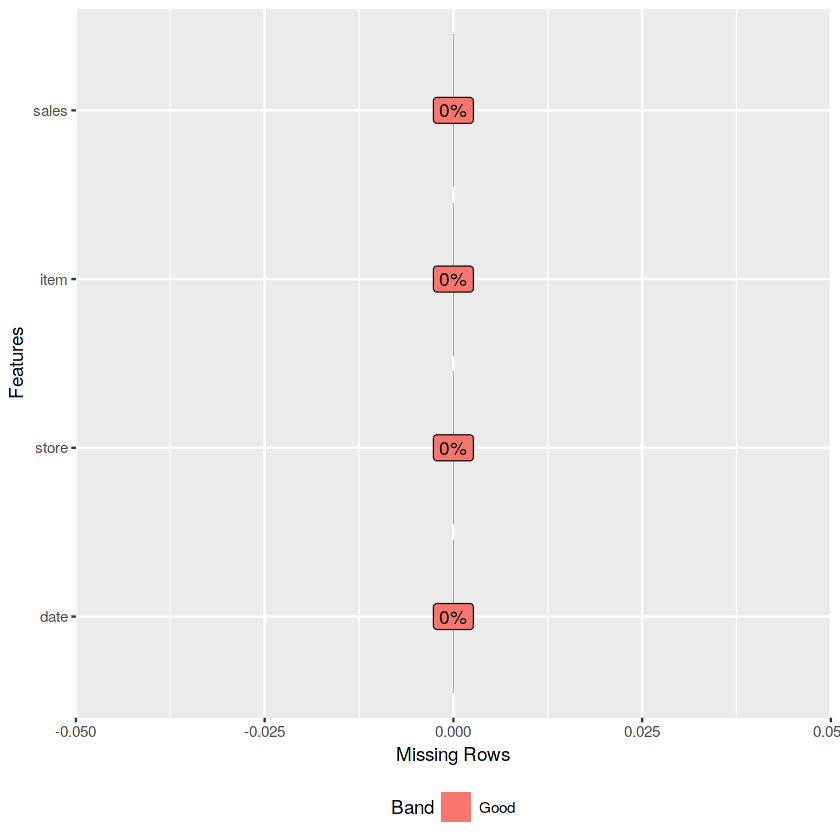

In [4]:
plot_missing(train)


In [5]:
# Check the data structure
glimpse(train)
glimpse(test)

#summary of train set
print("the summary of train sales is:")
summary(train$sales)


Rows: 913,000
Columns: 4
$ date  <date> 2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-05, 20…
$ store <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ item  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ sales <dbl> 13, 11, 14, 13, 10, 12, 10, 9, 12, 9, 9, 7, 10, 12, 5, 7, 16, 7…
Rows: 45,000
Columns: 4
$ id    <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…
$ date  <date> 2018-01-01, 2018-01-02, 2018-01-03, 2018-01-04, 2018-01-05, 20…
$ store <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ item  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
[1] "the summary of train sales is:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   30.00   47.00   52.25   70.00  231.00 

Warning message:
“Removed 90 row(s) containing missing values (geom_path).”


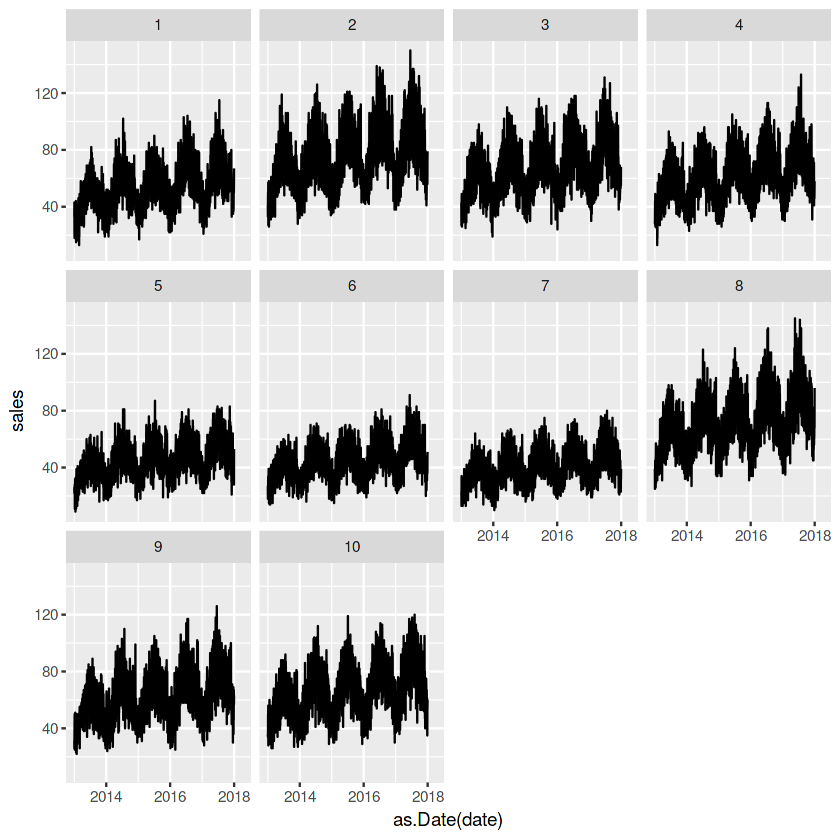

In [6]:
# Visualizations of item 2 sales at each store over time
ggplot(all_data %>% filter(item == 2), aes(x= as.Date(date), y = sales)) +
    geom_line() + 
    facet_wrap(~store)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



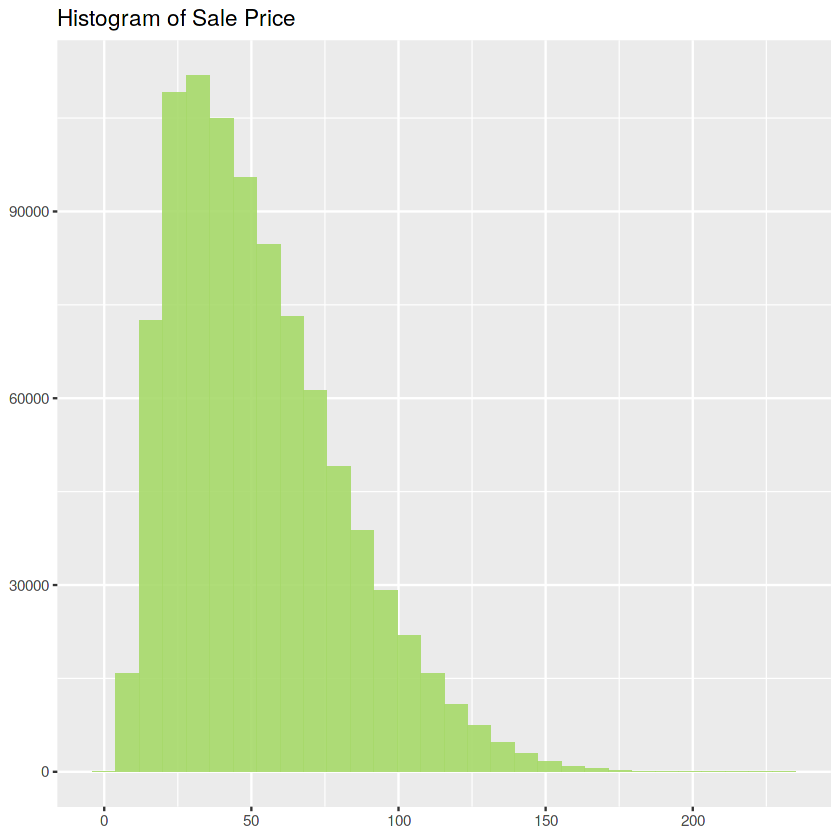

In [7]:
ggplot(train, aes(x=sales))+
  geom_histogram(fill="#a6d96a", alpha=.9)+
  labs(x=NULL, y=NULL, title = "Histogram of Sale Price")

Notice item 2 follows seasonal trends regardless of the store in which it is sold. This is true for all ten items. Time plays an important role here. The observations collected are dependent on the time at which it is collected. I therefore chose to use a time series model, facebook's prophet model, to handle the seasonality.

In [11]:
head(all_data)

date,store,item,sales,id
<date>,<fct>,<fct>,<dbl>,<dbl>
2013-01-01,1,1,13,NA
2013-01-02,1,1,11,NA
2013-01-03,1,1,14,NA
2013-01-04,1,1,13,NA
2013-01-05,1,1,10,NA
2013-01-06,1,1,12,NA


In [14]:
# Change items and stores to a factor
all_data <- all_data %>%
    mutate(item = factor(item), 
           store = factor(store))



library(StanHeaders)
train_2 <- train %>% 
    mutate(ds = date,
           y = sales) %>%
    select(ds,y, store, item)

test_2 <- test %>%
    mutate(ds = date) %>%
    select(ds, store,item, id)


**Prophet Model**
Beginning in 2017, a team at Facebook released ‘Prophet’, which utilizes a Bayesian based curve fitting method to forecast the time series data. This model is approachable for those without extensive knowledge in time series applications.

Advantages of propher model over traditional time series:
- automatically detect change points in the data
- implement holidays in the dataset
- regularize parameters using bayesian cross validation
See the Facebook Prophet documentation here: https://facebook.github.io/prophet/docs/trend_changepoints.html

In [15]:
m <- prophet(daily.seasonality=TRUE, n_changepoints = 0)
m <- add_country_holidays(m, country_name = 'US')
m <- add_regressor(m, 'store')
m <- add_regressor(m, 'item')
m <- fit.prophet(m, train_2)
forecast <- predict(m, test_2)
pred_frame <- data.frame(id = test$id, sales = forecast$yhat)
head(pred_frame)
write_csv(pred_frame, "submission.csv")

,id,sales
,<dbl>,<dbl>
1,0,36.06774
2,1,35.98582
3,2,35.90389
4,3,35.82197
5,4,35.74005
6,5,35.65812


**Next Steps**
I can further tune the prophet model parameters, including further feature engineering (weekday/weekend sales), or fit a seperate model for each item and each store.